<div style='padding:5px'><font style='font-weight:bold;font-size:32px;color:#2c3393;'>Here Comes The Sun: Cebu Solar Power Plant</font></div>
<div style='padding:5px'><font style='font-weight:bold;font-size:24px;color:#2c3393;'>LT16 - Sandro Silva and Jac Lin Yu</font></div>

------------

<font style='font-weight:bold;font-size:32px;color:#2c3393;'>Table of Contents</font>


<font style='font-size:16px'>
    
**[1. Problem Statement](#problem-statement)**

**[2. Methodology](#methodology)**

  * [2.1. Loading Prerequisites](#preq)
  * [2.2. Dataset and Preprocessing](#data)
  * [2.3. Train, Validation, Test Split and Batch Generation](#train)
  * [2.4. Determining the Benchmark](#benchmark)
  * [2.5. Model Training and Selection](#model)
      * [2.5.1 LSTM with 64 nodes](#lstm1)
      * [2.5.2 LSTM with 32 nodes](#lstm2)
      * [2.5.3 Stacked LSTM with 64 and 32 nodes](#lstm3)
      * [2.5.4 Stacked LSTM with 32 and 64 nodes](#lstm4)   

**[3. Results and Discussions](#results)**
  * [3.1. Results](#res)
  * [3.2. Discussions and Recommendations](#discussions)
    
</font>

<div id="problem-statement"/>
<div style='padding:3px;'> <font style='font-weight:bold;font-size:20px;color:#2c3393;'>1. Problem Statement</font></div>

<div style='padding-left: 20px; text-align: justify; font-size:16px; line-height:1.6'>
In recent years, the global energy industry has changed its focus away from traditional fuel sources, such as oil and coal, to more alternative and sustainable solutions, such as hydroelectric, solar and wind. However, the shift towards renewable energy poses new threats and challenges to existing power grids across the world. One major concern surrounding renewable energy generation is the inherent variability and intermittency of its fuel source, as this can cause disruptions in power grids. Essentially, renewable energy technologies threaten to overwhelm the grid operators.
<br><br> 
Renewable energy forecasting, in particular solar generation supply, may provide power grid operators the ability to predict and balance energy generation and consumption. In addition, power grid operators will be able to balance and schedule the distribution of generated power for not only renewable power plants but also conventional (and rigid) power plants, such as coal and natural gas.
</div>

<div id="methodology"/>
<div style='padding:5px;'> <font style='font-weight:bold;font-size:20px;color:#2c3393;'>2. Methodology</font></div>

<div id="preq"/>
<div style='padding:5px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>2.1 Loading Prerequisites</font></div>

In [66]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [67]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

<div id="data"/>
<div style='padding:5px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>2.2 Dataset and Preprocessing</font></div>

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
Here, we will load the already cleaned preprocessed dataset of solar generation per plant per hour.
The cleaning was processed outside of this notebook, and followed a framework which follows the industry standard of imputing missing values.
  
    
<b>To list a few processes:</b>
    - using the average between the before(t-1) and after hour(t+1)
    - using a 1-week average of all similar intervals 
    (ex, if empty during hour 6 of dec 20, take the moving average of all hour 6 from dec 13-dec19)
    - using a 4-week moving average of that specific hour and day of the week 
    (ex, if empty during hour 6 of dec 20, we take average of hour 6(dec 13, 6, 29, 22)
</font></div>

In [68]:
df = pd.read_excel('solar_dataset.xlsx', 
                   sheet_name='cebu', 
                   parse_dates=['DATETIME'])

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
Here let us observe the different datatypes, notice that some columns are objects, some of which will be dropped.
    </font></div>

In [9]:
df.dtypes

DATETIME         datetime64[ns]
YEAR                      int64
MONTH                     int64
DAY                       int64
HOUR                      int64
RESOURCE_ID              object
MW                      float64
Location                 object
Temperature             float64
Dew Point               float64
Humidity                float64
Wind Speed              float64
Wind Gust                 int64
Pressure                float64
Condition                object
Location_Name            object
dtype: object

In [10]:
df.head(3)

,DATETIME,YEAR,MONTH,DAY,HOUR,RESOURCE_ID,MW,Location,Temperature,Dew Point,Humidity,Wind Speed,Wind Gust,Pressure,Condition,Location_Name
0,2016-12-26 00:00:00,2016,12,26,1,5TOLSOL_G01,0.0,RPVM,79.0,77.0,94.0,1.0,0,29.7,Mostly Cloudy,MACTAN-CEBU
1,2016-12-26 01:00:00,2016,12,26,2,5TOLSOL_G01,0.0,RPVM,82.0,79.0,89.0,5.0,0,29.8,Mostly Cloudy,MACTAN-CEBU
2,2016-12-26 02:00:00,2016,12,26,3,5TOLSOL_G01,0.0,RPVM,84.0,79.0,84.0,6.0,0,29.8,Mostly Cloudy,MACTAN-CEBU


<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    It is customary in traditional time-series regression to convert the <code>month</code>, <code>day</code>, 
    <code>hour</code> into categorical data, which will be later used in one-hot encoding. In addition, this is the usual preprocessing used in the energy industry here in the Philippines.
</font></div>

In [11]:
df.MONTH = df.MONTH.astype('str')
df.DAY = df.DAY.astype('str')
df.HOUR = df.HOUR.astype('str')

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    Let us drop the unimportant columns
</font></div>

In [12]:
df.drop(['Location_Name', 'Location', "YEAR"],axis=1,inplace=True)

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    Let us append the main <code>df</code> with the one-hot encoded dataframe
</font></div>

In [13]:
df = df.join(pd.get_dummies(df[['MONTH','DAY','HOUR','Condition']]))

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    Let us get the unique list of power plants in the region
</font></div>

In [14]:
locations = df.RESOURCE_ID.unique()

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    For this study, let us consider the first power plant
</font></div>

In [15]:
locations[0]

'5TOLSOL_G01'

In [16]:
df0 = df[df.RESOURCE_ID == locations[0]].copy()

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    Further dropping of columns as well as reordering of columns
</font></div>

In [17]:
df0 = df0.drop(['RESOURCE_ID','DATETIME','MONTH','DAY','HOUR','Condition'],
               axis=1)

In [18]:
df0 = df0[['Temperature','MW'] + df0.columns[2:].tolist()].copy()

In [19]:
df0 = df0.astype('float')

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    Final <code>DataFrame</code> to be used
</font></div>

In [20]:
df0.head()

,Temperature,MW,Dew Point,Humidity,Wind Speed,Wind Gust,Pressure,MONTH_1,MONTH_10,MONTH_11,...,Condition_Partly Cloudy,Condition_Partly Cloudy / Windy,Condition_Rain,Condition_Rain / Windy,Condition_Rain Shower,Condition_Showers in the Vicinity,Condition_T-Storm,Condition_Thunder,Condition_Thunder / Windy,Condition_Thunder in the Vicinity
0,79.0,0.0,77.0,94.0,1.0,0.0,29.7,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,82.0,0.0,79.0,89.0,5.0,0.0,29.8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,84.0,0.0,79.0,84.0,6.0,0.0,29.8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,84.0,0.0,77.0,79.0,7.0,0.0,29.7,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,86.0,0.0,77.0,74.0,8.0,0.0,29.7,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df0.shape

(23160, 99)

In [22]:
plant_capacity = 60

<div id="train"/>
<div style='padding:5px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>
    2.3 Train,Validate,Test Split and Batch Generation</font></div>

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    For this analysis, a <code>.8</code>, <code>.1</code>, <code>.1</code>, train-validate-test split was implemented. Since we are dealing with a time-series, the train-validate-test split cannot be randomly selected from the dataset, splitting of dataset should be conducted in a chronogical order. Below we define the starting and ending <code>index</code> for each group
</font></div>

In [23]:
train_validate_test_split = [.8, .1, .1]

train_idx = math.floor(df0.shape[0] * train_validate_test_split[0])
val_idx = math.floor(df0.shape[0] * train_validate_test_split[1]) + train_idx

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    The <code>generator</code> function below was utilized to yield the appropriate batch. Significant parameters include the <code>lookback</code>, or how far back of the data to consider, <code>delay</code>, or how far into the future are we forecasting, <code>batch_size</code>, refers to the number of training examples utilized in one iteration.
</font></div>

In [24]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, 
              batch_size=128, step=1):
    
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, 
                                     max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    Let us mean-center the dataset
</font></div>

In [25]:
float_data = df0.values
train_mean = float_data[:train_idx].mean(axis=0)
float_data -= train_mean
train_std = float_data[:train_idx].std(axis=0)
float_data /= train_std
train_mw_std = train_std[1]

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    Let us initialize the parameters which will be used for the generation
    An industry standard practic is to utilize a <code>lookback</code> of either <code>144 hours</code> (1 week), <code>288 hours</code> (2 weeks), or <code>720 hours</code> (1[30-day] month). The initial run was to utilized a <code>288 hour</code> lookback period due to group's industry expert's experience. However, outside consultation with industry experts said 1 week would suffice with this limited dataset.
</font></div>

In [26]:
lookback = 144 # lookback(consider) the previous week data
step = 1 # in hourly granularity
delay = 24 # to forecast the next 24 hours
batch_size = 128

In [27]:
train_gen = generator(float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=train_idx,
    shuffle=True,
    step=step,
    batch_size=batch_size)

val_gen = generator(float_data,
    lookback=lookback,
    delay=delay,
    min_index=train_idx+1,
    max_index=val_idx,
    step=step,
    batch_size=batch_size)

test_gen = generator(float_data,
    lookback=lookback,
    delay=delay,
    min_index=val_idx,
    max_index=None,
    step=step,
    batch_size=batch_size)

val_steps = (val_idx - (train_idx+1) - lookback)
test_steps = (len(float_data) - (val_idx+1) - lookback)

<div id="benchmark"/>
<div style='padding:5px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>2.4 Benchmark</font></div>

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    The team used two metrics to establish a baseline error:
    
    (1) the naive method identified in a previous lecture, which we scaled to industry standard
    (2) a different framework suggested by industry
</font></div>

In [28]:
def evaluate_naive_method():

    batch_maes = []
    for step in range(val_steps):
        if step % 1000 == 0:
            print(step)
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    
    return np.mean(batch_maes)

naive_method = evaluate_naive_method()

0
1000
2000


In [29]:
print('NAIVE METHOD 1:', f'{((naive_method * train_mw_std)/plant_capacity):0.2%}') #where 22 is the capacity of the plant

NAIVE METHOD 1: 7.67%


In [30]:
benchmark1 = ((naive_method * train_mw_std)/plant_capacity) * 100

<div style='padding:5px;text-align:justify'> <font style='font-style:italic;font-size:17px;color:#2c3393;'>
For establishing the 2nd baseline error, the team consulted the industry to determine a baseline error. However, even the industry is still conflicted on how to establish a baseline measurement. As of now, the baseline is still being established by policy makers and grid operators. 
<br>   
    
Luckily, consulting with industry experts gave the team a framework on how to establish a baseline error per plant. The resulting measure looked at the mean squared error of the day-ahead projection(DAP), also called scheduled (Ex-Ante or RTD), and the actual delivered (Ex-Post or RTX).
    
    
This was then scaled as a percentage to the capacity of the plant. This was with processed with an industry expert and not included in the notebook. The yielding error resulted with a baseline of <code>15.34%</code>
</font></div>

In [31]:
benchmark2 = 15.34

<div id="model"/>
<div style='padding:5px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>2.5 Model Training Selection</font></div>

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
The team utilized 4 models:
    
    - LSTM with 64 nodes
    - LSTM with 32 nodes
    - Stacked LSTM(2 layer) with 64 and 32 nodes
    - Stacked LSTM(2 layer) with 32 and 64 nodes
    
Dropout of <code>0.2</code> and Recurrent Dropout of <code>0.2</code> and a <code>RMSProp</code> optimized was implemented for all three.

The group decided to use a <code>Epoch=50</code>, with an EarlyStopping of <code>patience=10</code> and <code>min_delta=0.01</code> to avoid overfitting and to reduce runtime due to the limited time constraints.
</font></div>

In [32]:
steps_per_epoch_cnt = math.floor(train_idx/batch_size)
val_steps_cnt = round(math.floor((val_idx-train_idx)/batch_size),-1)

<div id="lstm1"/>
<div style='padding:20px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>2.5.1 LSTM with 64</font></div>

In [33]:
filepath_lstm64="Cebu_best_lstm64.hdf5" 
cp_lstm64 = ModelCheckpoint(filepath_lstm64, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
es_lstm64 = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, min_delta=.01)
callbacks_list_lstm64 = [cp_lstm64, es_lstm64]

# fix random seed for reproducibility
seed = 1337
np.random.seed(seed)

model_lstm64 = Sequential()
model_lstm64.add(layers.LSTM(64, 
                       dropout=0.2,
                       recurrent_dropout=0.2, 
                       input_shape=(None, float_data.shape[-1])))
model_lstm64.add(layers.Dense(64,activation='relu'))
model_lstm64.add(layers.Dense(1))
model_lstm64.compile(optimizer=RMSprop(), loss='mae')

history_lstm64 = model_lstm64.fit_generator(train_gen,
                                        steps_per_epoch=steps_per_epoch_cnt, 
                                        epochs=50,
                                        validation_data=val_gen, 
                                        validation_steps=val_steps_cnt,
                                        callbacks=callbacks_list_lstm64, verbose=2) 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
20/20 [==============================] - 1s 65ms/step - loss: 0.2050

Epoch 00001: val_loss improved from inf to 0.20503, saving model to Cebu_best_lstm64.hdf5
 - 22s - loss: 0.3745 - val_loss: 0.2050
Epoch 2/50
20/20 [==============================] - 1s 42ms/step - loss: 0.2099

Epoch 00002: val_loss did not improve from 0.20503
 - 19s - loss: 0.2448 - val_loss: 0.2099
Epoch 3/50
20/20 [==============================] - 1s 44ms/step - loss: 0.1907

Epoch 00003: val_loss improved from 0.20503 to 0.19068, saving model to Cebu_best_lstm64.hdf5
 - 19s - loss: 0.2185 - val_loss: 0.1907
Epoch 4/50
20/20 [==============================] - 1s 44ms/step - loss: 0.1947

Epoch 00004: val_loss did not improve from 0.19068
 - 21s - loss: 0.1975 - val_loss

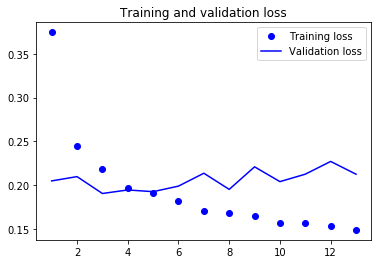

In [34]:
loss_lstm64 = history_lstm64.history['loss']
val_loss_lstm64 = history_lstm64.history['val_loss']

epochs = range(1, len(loss_lstm64) + 1)

plt.figure()

plt.plot(epochs, loss_lstm64, 'bo', label='Training loss')
plt.plot(epochs, val_loss_lstm64, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [35]:
print('Model Error:', f'{((min(val_loss_lstm64) * train_mw_std)/plant_capacity):0.2%}')

Model Error: 4.87%


In [59]:
lstm64 = ((min(val_loss_lstm64) * train_mw_std)/plant_capacity)  * 100

<div id="lstm2"/>
<div style='padding:20px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>2.5.2 LSTM with 32 nodes</font></div>

In [37]:
filepath_lstm32="Cebu_best_lstm32.hdf5" 
cp_lstm32 = ModelCheckpoint(filepath_lstm32, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
es_lstm32 = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, min_delta=.01)
callbacks_list_lstm32 = [cp_lstm32, es_lstm32]

# fix random seed for reproducibility
seed = 1337
np.random.seed(seed)

model_lstm32 = Sequential()
model_lstm32.add(layers.LSTM(32, 
                       dropout=0.2,
                       recurrent_dropout=0.2, 
                       input_shape=(None, float_data.shape[-1])))
model_lstm32.add(layers.Dense(32, activation='relu'))
model_lstm32.add(layers.Dense(1))
model_lstm32.compile(optimizer=RMSprop(), loss='mae')

history_lstm32 = model_lstm32.fit_generator(train_gen,
                                        steps_per_epoch=steps_per_epoch_cnt, 
                                        epochs=50,
                                        validation_data=val_gen, 
                                        validation_steps=val_steps_cnt,
                                        callbacks=callbacks_list_lstm32, verbose=2) 

Epoch 1/50
20/20 [==============================] - 1s 40ms/step - loss: 0.2389

Epoch 00001: val_loss improved from inf to 0.23892, saving model to Cebu_best_lstm32.hdf5
 - 18s - loss: 0.4182 - val_loss: 0.2389
Epoch 2/50
20/20 [==============================] - 1s 31ms/step - loss: 0.1922

Epoch 00002: val_loss improved from 0.23892 to 0.19216, saving model to Cebu_best_lstm32.hdf5
 - 16s - loss: 0.2575 - val_loss: 0.1922
Epoch 3/50
20/20 [==============================] - 1s 34ms/step - loss: 0.1897

Epoch 00003: val_loss improved from 0.19216 to 0.18967, saving model to Cebu_best_lstm32.hdf5
 - 16s - loss: 0.2250 - val_loss: 0.1897
Epoch 4/50
20/20 [==============================] - 1s 33ms/step - loss: 0.1686

Epoch 00004: val_loss improved from 0.18967 to 0.16857, saving model to Cebu_best_lstm32.hdf5
 - 17s - loss: 0.2017 - val_loss: 0.1686
Epoch 5/50
20/20 [==============================] - 1s 30ms/step - loss: 0.1814

Epoch 00005: val_loss did not improve from 0.16857
 - 17s -

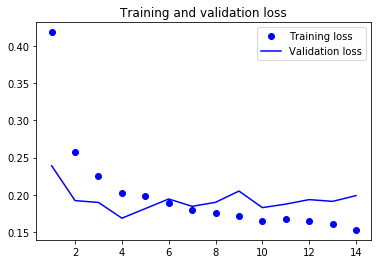

In [38]:
loss_lstm32 = history_lstm32.history['loss']
val_loss_lstm32 = history_lstm32.history['val_loss']

epochs = range(1, len(loss_lstm32) + 1)

plt.figure()

plt.plot(epochs, loss_lstm32, 'bo', label='Training loss')
plt.plot(epochs, val_loss_lstm32, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [39]:
print('Model Error:', f'{((min(val_loss_lstm32) * train_mw_std)/plant_capacity):0.2%}')

Model Error: 4.30%


In [58]:
lstm32 = ((min(val_loss_lstm32) * train_mw_std)/plant_capacity)  * 100

<div id="lstm3"/>
<div style='padding:20px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>2.5.3 Stacked LSTM with 64 and 32 nodes</font></div>

In [41]:
filepath_lstm6432="Cebu_best_lstm6432.hdf5" 
cp_lstm6432 = ModelCheckpoint(filepath_lstm6432, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
es_lstm6432 = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, min_delta=.01)
callbacks_list_lstm6432 = [cp_lstm6432, es_lstm6432]

# fix random seed for reproducibility
seed = 1337
np.random.seed(seed)

model_lstm6432 = Sequential()
model_lstm6432.add(layers.LSTM(64,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    return_sequences=True,
                    input_shape=(None, float_data.shape[-1])))
model_lstm6432.add(layers.LSTM(32,
                    dropout=0.2,
                    recurrent_dropout=0.2))
model_lstm6432.add(layers.Dense(32, activation='relu'))
model_lstm6432.add(layers.Dense(1))
model_lstm6432.compile(optimizer=RMSprop(), loss='mae')

history_lstm6432 = model_lstm6432.fit_generator(train_gen,
                                             steps_per_epoch=steps_per_epoch_cnt,
                                             epochs=50,
                                             validation_data=val_gen, 
                                             validation_steps=val_steps_cnt,
                                             callbacks=callbacks_list_lstm6432, verbose=2)

Epoch 1/50
20/20 [==============================] - 2s 93ms/step - loss: 0.2058

Epoch 00001: val_loss improved from inf to 0.20581, saving model to Cebu_best_lstm6432.hdf5
 - 40s - loss: 0.3520 - val_loss: 0.2058
Epoch 2/50
20/20 [==============================] - 1s 67ms/step - loss: 0.2092

Epoch 00002: val_loss did not improve from 0.20581
 - 39s - loss: 0.2220 - val_loss: 0.2092
Epoch 3/50
20/20 [==============================] - 2s 80ms/step - loss: 0.2094

Epoch 00003: val_loss did not improve from 0.20581
 - 41s - loss: 0.2063 - val_loss: 0.2094
Epoch 4/50
20/20 [==============================] - 1s 61ms/step - loss: 0.1837

Epoch 00004: val_loss improved from 0.20581 to 0.18374, saving model to Cebu_best_lstm6432.hdf5
 - 38s - loss: 0.1854 - val_loss: 0.1837
Epoch 5/50
20/20 [==============================] - 1s 64ms/step - loss: 0.1957

Epoch 00005: val_loss did not improve from 0.18374
 - 37s - loss: 0.1823 - val_loss: 0.1957
Epoch 6/50
20/20 [==============================]

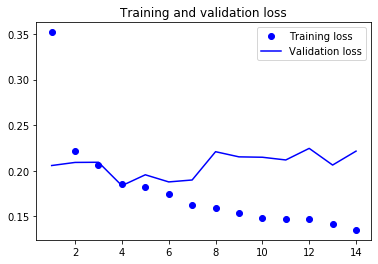

In [42]:
loss_lstm6432 = history_lstm6432.history['loss']
val_loss_lstm6432 = history_lstm6432.history['val_loss']

epochs = range(1, len(loss_lstm6432) + 1)

plt.figure()

plt.plot(epochs, loss_lstm6432, 'bo', label='Training loss')
plt.plot(epochs, val_loss_lstm6432, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [43]:
print('Model Error:', f'{((min(val_loss_lstm6432) * train_mw_std)/plant_capacity):0.2%}')

Model Error: 4.69%


In [57]:
lstm6432 = ((min(val_loss_lstm6432) * train_mw_std)/plant_capacity)  * 100

<div id="lstm4"/>
<div style='padding:20px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>2.5.4 Stacked LSTM with 32 and 64 nodes</font></div>

In [45]:
filepath_lstm3264 ="Cebu_best_lstm3264.hdf5" 
cp_lstm3264 = ModelCheckpoint(filepath_lstm3264, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
es_lstm3264 = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, min_delta=.01)
callbacks_list_lstm3264 = [cp_lstm3264, es_lstm3264]

# fix random seed for reproducibility
seed = 1337
np.random.seed(seed)

model_lstm3264 = Sequential()
model_lstm3264.add(layers.LSTM(64,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    return_sequences=True,
                    input_shape=(None, float_data.shape[-1])))
model_lstm3264.add(layers.LSTM(32,
                    dropout=0.2,
                    recurrent_dropout=0.2))
model_lstm3264.add(layers.Dense(64, activation='relu'))
model_lstm3264.add(layers.Dense(1))
model_lstm3264.compile(optimizer=RMSprop(), loss='mae')

history_lstm3264 = model_lstm3264.fit_generator(train_gen,
                                             steps_per_epoch=steps_per_epoch_cnt,
                                             epochs=50,
                                             validation_data=val_gen, 
                                             validation_steps=val_steps_cnt,
                                             callbacks=callbacks_list_lstm3264, verbose=2)

Epoch 1/50
20/20 [==============================] - 1s 71ms/step - loss: 0.1866

Epoch 00001: val_loss improved from inf to 0.18658, saving model to Cebu_best_lstm3264.hdf5
 - 38s - loss: 0.3441 - val_loss: 0.1866
Epoch 2/50
20/20 [==============================] - 1s 63ms/step - loss: 0.2028

Epoch 00002: val_loss did not improve from 0.18658
 - 34s - loss: 0.2206 - val_loss: 0.2028
Epoch 3/50
20/20 [==============================] - 1s 68ms/step - loss: 0.2007

Epoch 00003: val_loss did not improve from 0.18658
 - 36s - loss: 0.2065 - val_loss: 0.2007
Epoch 4/50
20/20 [==============================] - 1s 70ms/step - loss: 0.2070

Epoch 00004: val_loss did not improve from 0.18658
 - 38s - loss: 0.1875 - val_loss: 0.2070
Epoch 5/50
20/20 [==============================] - 1s 74ms/step - loss: 0.2092

Epoch 00005: val_loss did not improve from 0.18658
 - 37s - loss: 0.1841 - val_loss: 0.2092
Epoch 6/50
20/20 [==============================] - 1s 63ms/step - loss: 0.1759

Epoch 00006: 

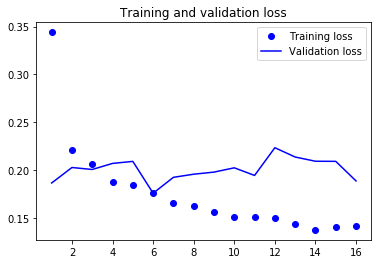

In [46]:
loss_lstm3264 = history_lstm3264.history['loss']
val_loss_lstm3264 = history_lstm3264.history['val_loss']

epochs = range(1, len(loss_lstm3264) + 1)

plt.figure()

plt.plot(epochs, loss_lstm3264, 'bo', label='Training loss')
plt.plot(epochs, val_loss_lstm3264, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [47]:
print('Model Error:', f'{((min(val_loss_lstm3264) * train_mw_std)/plant_capacity):0.2%}')

Model Error: 4.49%


In [56]:
lstm3264 = ((min(val_loss_lstm3264) * train_mw_std)/plant_capacity) * 100

In [54]:
lstm3264

0.0448781794602682

<div id="results"/>
<div style='padding:3px;'> <font style='font-weight:bold;font-size:20px;color:#2c3393;'>3. Results and Discussions</font></div>

<div id="res"/>
<div style='padding:10px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>3.1 Results</font></div>

In [61]:
names = ['Industry Agnostic Naive Method',
         'Industry Standard Naive Method', 
         'LSTM with 64 nodes',
         'LSTM with 32 nodes',
         'LSTM+LSTM with 64 nodes and 32 nodes',
         'LSTM+LSTM with 32 nodes and 64 nodes']
results = [benchmark1, 
           benchmark2,
           lstm64,
           lstm32,
           lstm6432,
           lstm3264]

In [62]:
results = pd.DataFrame(zip(names,results), columns=['Model', 'Error in Percentage'])

In [63]:
results['Error in Percentage'] = round(results['Error in Percentage'],2)

In [64]:
results['Improvement'] = round(1-(results['Error in Percentage']/benchmark2),4)*100

In [65]:
results

,Model,Error in Percentage,Improvement
0,Industry Agnostic Naive Method,7.67,50.00
1,Industry Standard Naive Method,15.34,0.00
2,LSTM with 64 nodes,4.87,68.25
3,LSTM with 32 nodes,4.30,71.97
4,LSTM+LSTM with 64 nodes and 32 nodes,4.69,69.43
5,LSTM+LSTM with 32 nodes and 64 nodes,4.49,70.73
